In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import textwrap
import seaborn as sn
sn.color_palette("hls", 17)
import scipy.stats as st
import math

import pingouin as pg
plt.rcParams["font.family"] = "Times New Roman"

c:\Users\srandrad\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import sys
import os
sys.path.append(os.path.join("..", "..", ".."))

from mika.kd.trend_analysis import *
from mika.utils import Data
from mika.utils.SAFECOM import *

c:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
c:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
c:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
c:\Users\srandrad\Anaconda3\lib\site-packages\plotly\graph_objs\__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
c:\Users\srandrad\Anaconda3\lib\

In [3]:
csv_file_name = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)),'data','SAFECOM','SAFECOM_data.csv')
df = pd.read_csv(csv_file_name)
fire_missions = [mission for mission in list(df['Mission Type']) if type(mission) is str and 'fire' in mission.lower()]
df = df.loc[df['Mission Type'].isin(fire_missions)].reset_index(drop=True)
df['Year'] = [df.at[i,'Date'].split('/')[-1] for i in range(len(df))]
df['Day'] = [df.at[i,'Date'].split('/')[1] for i in range(len(df))]
df['Month'] = [df.at[i,'Date'].split('/')[0] for i in range(len(df))]
#df['Year'].value_counts()

c:\Users\srandrad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#NIFC based in boise
#idaho and wyoming are split in regions
def correct_regions(df):
    region_dict ={
        'Region 05 Pacific Southwest Region': ['5', 'California', 'Hawaii', 'Pacific West Regional Office','California State Office','R2-Southwest Regional Office', 'National Guard'],
        'Region 06 Pacific Northwest Region':['Oregon/Washington State Office', 'Washington', 'Oregon', 'Washington Office','R9-Washington Office',
                                             'PNW Research Station FIA','R1-Pacific Regional Office'],
        'Region 01 Northern Rockies Region':['Montana/Dakotas State Office', 'Montana'], 
        'Region 04 Intermountain Region':['Nevada State Office','DOI-OAS - Headquarters Boise', 'Intermountain Regional NPS Headquarters',
                                         'Utah','Utah State Office', 'Nevada', 'National Interagency Fire Center', 'DOI-OAS - Western Region Office',
                                         'DOI-OAS - Technical Services', 'DOI-OAS - Unmanned Aircraft System Office'],
        'Region 03 Southwest Region':['Southeast Region','Arizona State Office','Arizona','New Mexico','New Mexico State Office'],
        'Region 09 Eastern Area Region':['New Jersey', 'Pennsylvania', 'Minnesota','Pennsylvania','Midwest Regional NPS Headquarters','R3-Great Lakes - Big Rivers Regional Office',
                                        'Northeast Regional Office', 'DOI-OAS - Eastern Region Office','Northeastern Area, S&PF','Wisconsin','Eastern States Office','National Capitol Parks'],
        'Region 02 Rocky Mountain Region':['Colorado State Office', 'Colorado','R6-Mountain-Praire Regional Office', 'DMBM - Migratory Birds', 'Wyoming', 'South Dakota', 'Nebraska'], 
        'Region 08 Southern Area Region':['Gulf of Mexico Region','Texas','Oklahoma','North Carolina', 'South Carolina','Florida','R4-Southeast Regional Office', 'Tennessee', 'Georgia', 'Louisiana', 'Virginia'],
        'Region 10 Alaska Region': ['Alaska State Office','Alaska OCS Region', 'Alaska Regional Office', 'Alaska','DOI-OAS - Alaska Regional Office',
                                   'R7-Alaska Regional Office']

    }
    regions_corrected = []
    indices_to_drop = []
    for i in range(len(df)):
        current_region = df.iloc[i]['Region']
        correct_region = None
        for region in region_dict:
            if (region == current_region) or (current_region in region_dict[region]):
                correct_region = region
                break 
        if not correct_region:
            correct_region = current_region
        if correct_region in ['CAMP â€“ Campaign Against Marijuana Program', 'Commercial Aircraft Services', 'Aircraft Operations Center','National Capitol Parks', 'Department of Defense', 'National Guard']:
            indices_to_drop.append(i)
        if correct_region == 'Idaho':
            if df.iloc[i]['Location'] in ['Clear Creak Fire', 'garden valley', 'Idaho City', 'Idaho City Helibase (U98)','Ranft Fire']:
                correct_region = 'Region 04 Intermountain Region'
            else:
                correct_region = 'Region 01 Northern Rockies Region'
        elif correct_region == 'Pacific Region':
            correct_region = 'Region 05 Pacific Southwest Region'
        elif correct_region == 'Idaho State Office':
            if df.iloc[i]['Location'] in ['Granite Creek Fire', '47.512775, -116.002886','Post Falls, ID']:
                correct_region = 'Region 01 Northern Rockies Region'
            else: 
                correct_region = 'Region 04 Intermountain Region'
        elif correct_region == 'Wyoming State Office':
            if df.iloc[i]['Location'] in ['Tokewanna Fire','Rock Springs Sweetwater County', 'Evanston, WY Airport']:
                correct_region = 'Region 04 Intermountain Region'
            else:
                correct_region = 'Region 02 Rocky Mountain Region'
        regions_corrected.append(correct_region)

    df['region_corrected'] = regions_corrected
    df = df.drop(indices_to_drop, axis=0).reset_index(drop=True)
    return df

In [5]:
list_of_attributes = ['Narrative']#, 'corrective_public', 'notes']
extra_cols = ['Agency', 'Region', 'Location', 'Date', 'Date Submitted', 'Tracking #',
              'Mission Type', 'Persons Onboard', 'Departure Point', 'Destination',
              'Special Use', 'Damages', 'Injuries', 'Hazardous Materials', 'Other Mission Type',
              'Type', 'Manufacturer', 'Model', 'Hazard', 'Incident Management',
              'UAS', 'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention'
              ]
document_id_col = 'Tracking #'

file = os.path.join('topic_model_results','preprocessed_data.csv')
safecom = Data()
safecom.load(file, preprocessed=True, id_col=document_id_col, text_columns=list_of_attributes)
preprocessed_df = safecom.data_df
preprocessed_df['Year'] = [preprocessed_df.at[i,'Date'].split('/')[-1] for i in range(len(preprocessed_df))]
preprocessed_df['Day'] = [preprocessed_df.at[i,'Date'].split('/')[1] for i in range(len(preprocessed_df))]
preprocessed_df['Month'] = [preprocessed_df.at[i,'Date'].split('/')[0] for i in range(len(preprocessed_df))]

In [6]:
preprocessed_df.columns

Index(['Agency', 'Region', 'Location', 'Date', 'Date Submitted', 'Tracking #',
       'Mission Type', 'Persons Onboard', 'Departure Point', 'Destination',
       'Special Use', 'Damages', 'Injuries', 'Hazardous Materials',
       'Other Mission Type', 'Type', 'Manufacturer', 'Model', 'Narrative',
       'Hazard', 'UAS', 'Accident', 'Airspace', 'Maintenance',
       'Mishap Prevention', 'Raw_Narrative', 'Year', 'Day', 'Month'],
      dtype='object')

In [7]:
preprocessed_df = preprocessed_df.loc[(preprocessed_df['Year'].astype(int)<2021) & (preprocessed_df['Year'].astype(int)>1994)].reset_index(drop=True)

In [8]:
hazard_file = os.path.join('topic_model_results', 'hazard_interpretation_SAFECOM_Final.xlsx')
results_file = os.path.join('topic_model_results','lda_results.xlsx')

In [9]:
#hazard_info = pd.read_excel(hazard_file, sheet_name=['topic-focused'])

In [10]:
#remove ids from results file and preprocessed_df if the mission is non-fire
non_fire_missions = [mission for mission in list(preprocessed_df['Mission Type']) if type(mission) is str and 'non-fire' in mission.lower()]
ids_to_drop = preprocessed_df.loc[preprocessed_df['Mission Type'].isin(non_fire_missions)]['Tracking #'].tolist()
preprocessed_df = preprocessed_df.loc[~preprocessed_df['Tracking #'].isin(ids_to_drop)].reset_index(drop=True)
print(len(ids_to_drop))

1983


In [11]:
preprocessed_df['Narrative']

0        [practice, target, mile, parachutist, still, j...
1        [agl, jump, spot, horizontal separation, separ...
2        [rpm, switch, stop, generator warn light, decr...
3        [clear, bottom, possible, cortez, found, glass...
4        [help, attack, jump, alaska, minute later, pub...
                               ...                        
12549    [know, input, crew, time, descent, still, miss...
12550    [replacement, blade, service, attention, broug...
12551    [engine, found, aware, bird strike, small, not...
12552    [post, attack, gauge, normal, blade, found, co...
12553    [expect, clearance, believe, maneuver, crew, t...
Name: Narrative, Length: 12554, dtype: object

In [12]:
frequency, docs, hazard_words_per_doc, topics_per_doc, hazard_topics_per_doc = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Narrative', 'Year', "Tracking #", 'Narrative', doc_topic_dist_field='document topic distribution', topic_thresh=0.2)#,  ids_to_drop= ids_to_drop)

100%|██████████| 26/26 [01:30<00:00,  3.48s/it]


In [13]:
#_ = hazard_accuracy(docs, num=15, results_path=os.path.join(os.path.dirname(os.getcwd()),'results','SAFECOM_hazards_lda_topics_Apr-04-2022'))

In [14]:
#frequency, docs = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Raw_Narrative', 'Year', "Tracking #", 'Narrative_reduced_BERT_topics')

In [15]:
def safecom_severity(passengers, injury, damage):
    key_dict = {"No":0, "Yes":1}
    if passengers == '':
        passengers = 0
    severity = float(passengers)*(key_dict[injury] + key_dict[damage])
    if np.isnan(severity):
        severity=0
    return severity

In [16]:
def calc_rate(frequency):
    total_hazard_freq = {hazard: sum(frequency[hazard].values()) for hazard in frequency}
    time_period = max([len(frequency[hazard].keys()) for hazard in frequency])
    rates = {hazard: round(total_hazard_freq[hazard]/time_period, 3) for hazard in total_hazard_freq}
    return rates

In [17]:
def calc_severity(docs, preprocessed_df, id_field):
    #time_period = preprocessed_df[time_field].unique()
    time_period = set([t for hazard in docs for t in (docs[hazard].keys())])
    severities = {name:{str(time_p):[] for time_p in time_period} for name in docs}
    for hazard in docs:
        for year in docs[hazard]:
            for doc in docs[hazard][year]:
                doc_df = preprocessed_df.loc[preprocessed_df[id_field] == doc].reset_index(drop=True)
                severities[hazard][year].append(safecom_severity(doc_df.iloc[0]['Persons Onboard'], doc_df.iloc[0]['Injuries'], doc_df.iloc[0]['Damages']))
    total_severities_hazard = {hazard: round(np.average([sev for year in severities[hazard] for sev in severities[hazard][year]]),3) for hazard in severities}
    return severities, total_severities_hazard

In [18]:
def create_table(docs, frequency, preprocessed_df, id_field, categories, subcategories, hazards, time_field, accuracy_file):
    table = pd.DataFrame({"Category": categories, "Subcategory": subcategories, "Hazards": hazards})
    accuracy_df = pd.read_excel(accuracy_file, sheet_name=['Summary'])['Summary']
    time_period = preprocessed_df[time_field].unique()
    severities = {name:{str(time_p):[] for time_p in time_period} for name in hazards}
    rates = {name:{str(time_p):0 for time_p in time_period} for name in hazards}
    total_docs_per_year = preprocessed_df[time_field].value_counts()
    total_rates = {hazard:0 for hazard in hazards}
    total_hazard_freq = {hazard:0 for hazard in hazards}
    total_severities_hazard = {hazard:0 for hazard in hazards}
    total_docs = len(preprocessed_df)
    precision = []
    for hazard in hazards:
        hazard_precision = accuracy_df.loc[accuracy_df['Hazards']==hazard].reset_index(drop=True)['Accuracy'].tolist()[0]
        precision.append(round(hazard_precision,3))
        for year in docs[hazard]:
            year = str(year)
            for doc in docs[hazard][year]:
                doc_df = preprocessed_df.loc[preprocessed_df[id_field] == doc].reset_index(drop=True)
                severities[hazard][year].append(safecom_severity(doc_df.iloc[0]['Persons Onboard'], doc_df.iloc[0]['Injuries'], doc_df.iloc[0]['Damages']))
            rates[hazard][year] = frequency[hazard][year]/total_docs_per_year[year]
            total_hazard_freq[hazard] += frequency[hazard][year]
        total_rates[hazard] = round(total_hazard_freq[hazard]/len(time_period), 3)
        total_severities_hazard[hazard] = round(np.average([sev for year in severities[hazard] for sev in severities[hazard][year]]),3)
    table["Frequency"] = [total_hazard_freq[hazard] for hazard in total_hazard_freq]
    table["Rate"] = [total_rates[hazard] for hazard in total_rates]
    table["Severity"] = [total_severities_hazard[hazard] for hazard in total_severities_hazard]
    table["Precision"] = precision
    return table, severities, rates
    

In [19]:
def get_categories_from_docs(docs, preprocessed_df, id_field, category_fields = ['Hazard', 'UAS', 'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention']):
    categories = {hazard: [] for hazard in docs}
    sub_categories = {hazard: [] for hazard in docs}
    for hazard in docs:
        ids = [id_ for year in docs[hazard] for id_ in docs[hazard][year]]
        hazard_df = preprocessed_df.loc[preprocessed_df[id_field].isin(ids)].reset_index(drop=True)
        #main category is the category with the most reports
        cat_counts = {}
        for cat in category_fields:
            cat_counts[cat] = len(hazard_df.loc[hazard_df[cat].notna()])
        main_category = max(cat_counts, key=cat_counts.get)
        categories[hazard] = main_category
        #subcategories are the most common value in that catgeory
        if len(hazard_df[main_category].value_counts()) == 0:
            sub_categories[hazard] = ""
        else:
            sub_cats = hazard_df[main_category].tolist()
            sub_cats = [cat for sub_cat in sub_cats for cat in str(sub_cat).split(", ")]
            sub_cats =[cat for cat in sub_cats if cat != 'nan']
            sub_cat_series = pd.Series(sub_cats).dropna()
            sub_categories[hazard] = sub_cat_series.value_counts().idxmax(axis = 0)
    return categories, sub_categories

In [20]:
hazards_to_drop = ['Runway Hazards', 'Runway Collisions', 'Refuel Truck Problems']
hazards = [hazard for hazard in frequency if hazard not in hazards_to_drop]
docs = {hazard:docs[hazard] for hazard in hazards}
categories, sub_categories = get_categories_from_docs(docs, preprocessed_df, "Tracking #")
categories = categories.values()
subcategories = sub_categories.values()
accuracy_file = os.path.join('topic_model_results','hazard_extraction_accuracy_final.xlsx')
table, severities, rates = create_table(docs, frequency, preprocessed_df, "Tracking #", categories, subcategories, hazards, 'Year', accuracy_file)

In [21]:
table = table.sort_values(['Category', 'Subcategory'], axis=0).reset_index(drop=True)
df = table[['Category', 'Subcategory']]
ind = pd.MultiIndex.from_frame(df)
table.index = ind
table = table.drop(['Category', 'Subcategory'], axis=1)

In [22]:
table

Hazards  Frequency  \
Category Subcategory                                                       
Hazard                                   Hydraulic Fluid Leak        307   
                                                    Intrusion        526   
                                          Bucket Drop Failure       1560   
                                       Tanker Loading Failure        813   
                                            Radio Malfunction        826   
                           On-board Caution Light Illuminates        338   
                                         Avionics Malfunction        517   
                                               Severe Weather        330   
                                     Landing Gear Malfunction        313   
                                          In-flight Collision        112   
                                     Airspace Control Hazards        104   
                                    Jumper Operations Hazards         57   
                                       Control Surface Damage        471   
                                 Helitorch Operations Failure        243   
                                           Engine Malfunction       1693   
                                              Oil Malfunction        589   
                                         Load Limits Exceeded         46   
                                        Cargo Letdown Failure        464   
                                                 Door Failure        490   
                                                      Medivac         51   
                                      Fuel System Malfunction       1793   
         Policy Deviation                      Inadequate PPE         36   
         Policy Deviation       Personnel Duty Hours Exceeded         77   

                             Rate  Severity  Precision  
Category Subcategory                                    
Hazard                     11.808     0.137      0.933  
                           20.231     0.004      1.000  
                           60.000     0.401      0.733  
                           31.269     0.150      0.733  
                           31.769     0.070      0.933  
                           13.000     0.036      1.000  
                           19.885     0.099      0.933  
                           12.692     0.552      0.800  
                           12.038     0.351      0.933  
                            4.308     0.759      0.800  
                            4.000     0.029      0.800  
                            2.192     3.561      0.800  
                           18.115     0.527      0.800  
                            9.346     0.230      0.800  
                           65.115     0.108      0.933  
                           22.654     0.107      1.000  
                            1.769     0.065      0.867  
                           17.846     0.241      0.800  
                           18.846     0.690      0.867  
                            1.962     2.137      1.000  
                           68.962     0.149      0.733  
         Policy Deviation   1.385     0.000      0.800  
         Policy Deviation   2.962     0.026      0.800

In [23]:
#table.to_csv(os.path.join(os.path.dirname(os.getcwd()), 'results', 'SAFECOM_hazards.csv'))

In [24]:
average_precision = np.average(table['Precision'].tolist())
std_precision = np.std(table['Precision'].tolist())
print(average_precision, std_precision)

0.8607826086956524 0.08990717750606872


In [25]:
docs_per_hazard = {hazard:[doc for year in docs[hazard] for doc in docs[hazard][year]] for hazard in docs}

In [26]:
hazards = []; tracking_num = []

In [27]:
for hazard in docs_per_hazard:
    for num in docs_per_hazard[hazard]:
        hazards.append(hazard)
        tracking_num.append(num)
hazard_docs_df = pd.DataFrame({"Hazard":hazards,
                              "Tracking #": tracking_num})

In [28]:
hazards_for_analysis = ['Hydraulic Fluid Leak', 'Intrusion', 'Bucket Drop Failure','Radio Malfunction',
                       'Jumper Operations Hazards', 'Tanker Loading Failure', 'Helitorch Operations Failure',
                       'Cargo Letdown Failure', 'Severe Weather']

In [29]:
sample_for_accuracy(preprocessed_df, id_col='Tracking #', text_col='Raw_Narrative', hazards=hazards, save_path=os.path.join(os.getcwd(), 'hazard_validation.csv'), num_sample=1000)

,Tracking #,Raw_Narrative,Hydraulic Fluid Leak,Intrusion,Bucket Drop Failure,Tanker Loading Failure,Radio Malfunction,On-board Caution Light Illuminates,Inadequate PPE,Avionics Malfunction,...,Jumper Operations Hazards,Control Surface Damage,Helitorch Operations Failure,Engine Malfunction,Oil Malfunction,Load Limits Exceeded,Cargo Letdown Failure,Door Failure,Medivac,Fuel System Malfunction
0,01-0943,Tanker 123 was dropping on the Castle Peak Fir...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,02-1289,Upon doing pre-use inspection I noticed fuel o...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,00-0211,"Upon arrival at the airport, and inspection of...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,98-0399,While returning to California from the Florida...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,18-0853,Upon completing recon missions of several fire...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12-1029,On 9/4/12 the xxx Helitack crew arrived at xxx...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,98-0392,Intermittent Radio Problem in the Plane:* Radi...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,97-0148,"The helicopter was trailered to Boise, ID. A n...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,13-0193,Upon landing at the tanker base T-XX was requi...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#updat: frequency, docs, severities, rates, hazards
frequency = {hazard: frequency[hazard] for hazard in hazards_for_analysis}
docs = {hazard: docs[hazard] for hazard in hazards_for_analysis}
severities = {hazard: severities[hazard] for hazard in hazards_for_analysis}
rates = {hazard: rates[hazard] for hazard in hazards_for_analysis}
hazards = hazards_for_analysis

c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


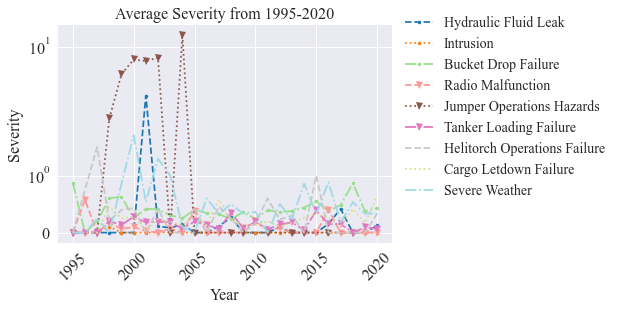

In [31]:
markers = ['.','.','.', 'v', 'v','v', 'x', 'x', 'x']
line_styles = ['--', ':','-.','--', ':','-.','--', ':','-.']

plot_metric_time_series(metric_data=severities, metric_name="Severity", line_styles=line_styles, markers=markers, title="Average Severity from 1995-2020", yscale='log', time_name='Year', show_std=False, save=False)
#plot_metric_time_series(metric_data=severities, metric_name="Severity", line_styles=line_styles, markers=markers, title="Average Severity from 1995-2020", time_name='Year', show_std=True, save=False)

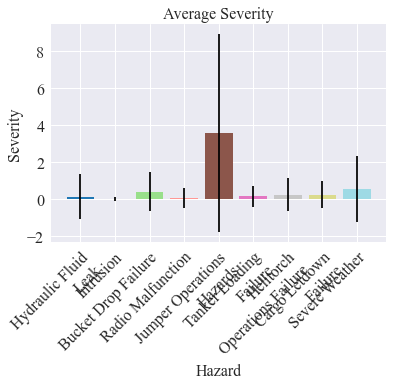

In [32]:
plot_metric_averages(metric_data=severities, metric_name="Severity", show_std=True, title="Average Severity", save=False, legend=False)

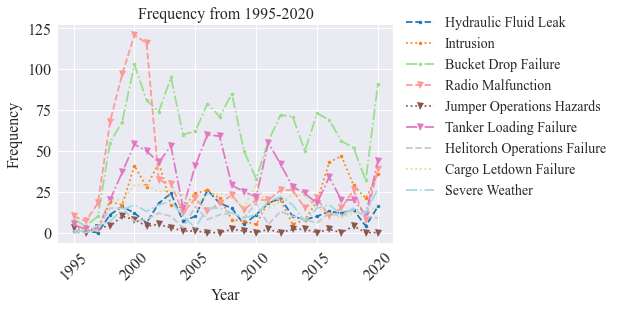

In [33]:
plot_frequency_time_series(frequency, metric_name='Frequency', line_styles=line_styles, markers=markers, title="Frequency from 1995-2020", time_name="Year", scale=False, save=False)

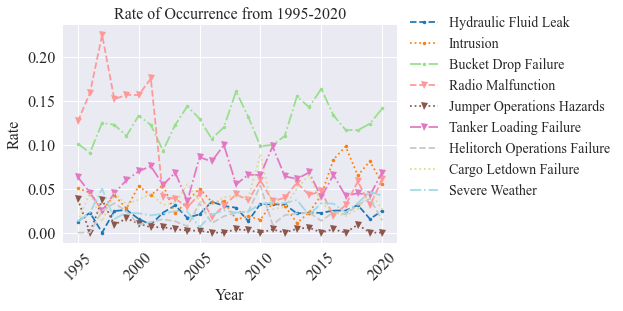

In [34]:
plot_frequency_time_series(rates, metric_name='Rate', line_styles=line_styles, markers=markers, title="Rate of Occurrence from 1995-2020", time_name="Year", scale=False, save=False)

# Pie Charts

In [35]:
print(len(preprocessed_df))
preprocessed_df = correct_regions(preprocessed_df)#correct_regions(preprocessed_df)
print(len(preprocessed_df))
preprocessed_df.columns

12554
12551


Index(['Agency', 'Region', 'Location', 'Date', 'Date Submitted', 'Tracking #',
       'Mission Type', 'Persons Onboard', 'Departure Point', 'Destination',
       'Special Use', 'Damages', 'Injuries', 'Hazardous Materials',
       'Other Mission Type', 'Type', 'Manufacturer', 'Model', 'Narrative',
       'Hazard', 'UAS', 'Accident', 'Airspace', 'Maintenance',
       'Mishap Prevention', 'Raw_Narrative', 'Year', 'Day', 'Month',
       'region_corrected'],
      dtype='object')

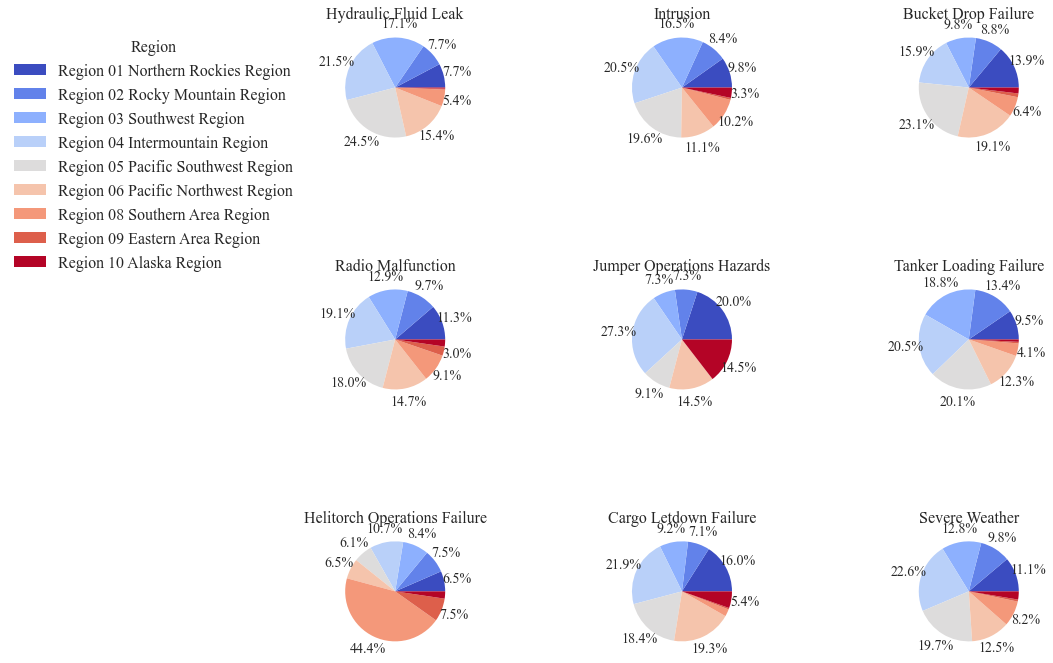

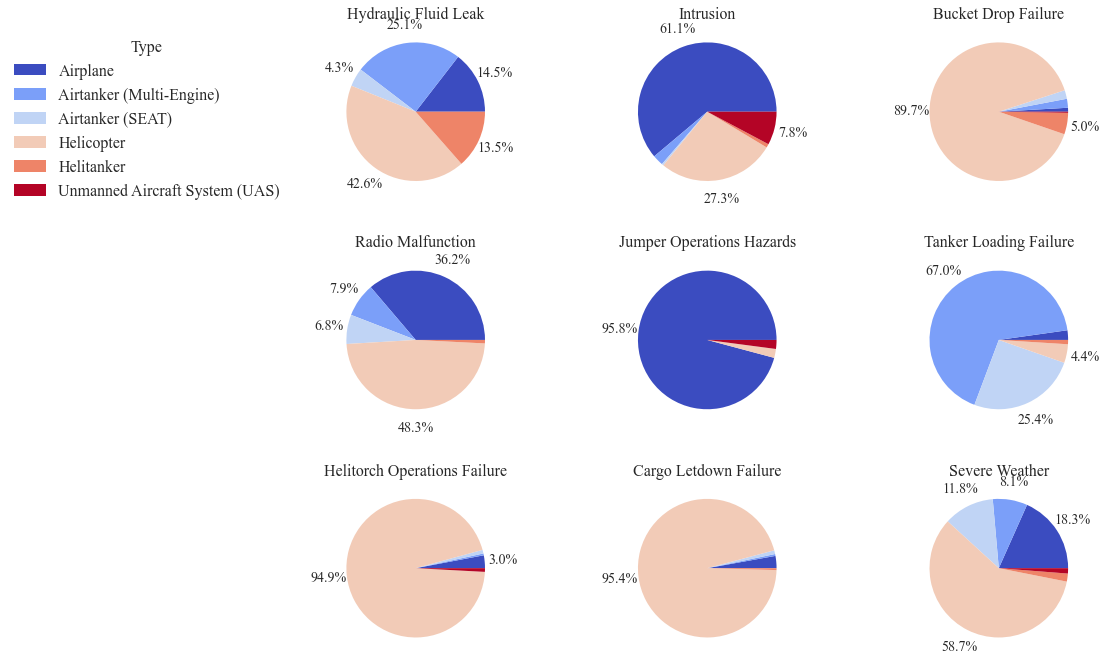

In [36]:
predictors = ['region_corrected', 'Type']#, 'Manufacturer', 'Model','Mission Type']
pie_kwargs = {'pctdistance':1.27}
for predictor in predictors:
    if predictor == 'region_corrected': 
        predictor_label='Region'
    else:
        predictor_label = None
    make_pie_chart(docs, preprocessed_df, predictor, hazards, 'Tracking #', predictor_label, save=False, padding=0, pie_kwargs=pie_kwargs)

# Chi-Squared Analysis

In [37]:
#add hazard values to preprocessed_df
hazards_per_doc = {doc:[] for doc in preprocessed_df['Tracking #']}
hazards_col = ["None" for i in range(len(preprocessed_df))]
hazards_for_df = {hazard:[0 for i in range(len(preprocessed_df))] for hazard in docs}
for hazard in docs:
    for year in docs[hazard]:
        for doc in docs[hazard][year]:
            if doc in preprocessed_df['Tracking #'].tolist():
                hazards_for_df[hazard][preprocessed_df.index[preprocessed_df['Tracking #']==doc].tolist()[0]] = 1
                if hazards_col[preprocessed_df.index[preprocessed_df['Tracking #']==doc][0]] =="None":
                    hazards_col[preprocessed_df.index[preprocessed_df['Tracking #']==doc][0]] = hazard
                else:
                    hazards_col[preprocessed_df.index[preprocessed_df['Tracking #']==doc][0]] += hazard
    preprocessed_df[hazard] = hazards_for_df[hazard]
preprocessed_df['hazard'] = hazards_col
#add severities
severities = []
for i in range(len(preprocessed_df)):
    severities.append(safecom_severity(preprocessed_df.iloc[i]['Persons Onboard'], preprocessed_df.iloc[i]['Injuries'], preprocessed_df.iloc[i]['Damages']))
preprocessed_df["severity"] = severities

In [38]:
count_dfs = {}
pred_dict = {'region_corrected':'Region', 'Type': "Aircraft Type", 'Agency':'Agency'}
stat_vals = {(pred_dict[pred],val): [] for pred in predictors for val in ["chi-squared", "p-val"]}
for predictor in predictors:
    vals = []
    hazard_vals = []
    pred_vals = [val for val in preprocessed_df[predictor].value_counts().index]
    diff_observed_expected = {pred_val:[] for pred_val in pred_vals}
    for hazard in hazards:
        expected, observed, stats = pg.chi2_independence(preprocessed_df, x=predictor,y=hazard)
        stat_vals[(pred_dict[predictor], "p-val")].append((stats.iloc[0]['pval'].round(3)))
        stat_vals[(pred_dict[predictor], "chi-squared")].append((stats.iloc[0]['chi2'].round(3)))
        for i in range(len(expected)):
            pred_val = expected.index[i]
            diff_observed_expected[pred_val].append(observed.iloc[i][0] - expected.iloc[i][0])
            diff_observed_expected[pred_val].append(observed.iloc[i][1] - expected.iloc[i][1])
    iterables = [hazards, [0,1]]
    index = pd.MultiIndex.from_product(iterables, names=["Hazard", "Present"])
    pred_df = pd.DataFrame(diff_observed_expected, index=index)
    count_dfs[predictor] = pred_df
iterables = [[pred_dict[pred] for pred in predictors], ["p-val", "chi-squared"]]
index = pd.MultiIndex.from_product(iterables, names=["Predictor", "Measure"])
stats_df = pd.DataFrame(stat_vals, index=hazards, columns=index)

c:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6713: RuntimeWarning: divide by zero encountered in true_divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)


In [39]:
stats_df

Predictor                    Region             Aircraft Type            
Measure                       p-val chi-squared         p-val chi-squared
Hydraulic Fluid Leak          0.000      34.975           0.0     122.696
Intrusion                     0.017      20.097           0.0     875.793
Bucket Drop Failure           0.000      74.493           0.0    1045.168
Radio Malfunction             0.000      37.679           0.0     230.866
Jumper Operations Hazards     0.000      41.014           0.0     164.577
Tanker Loading Failure        0.000     117.405           0.0    2957.462
Helitorch Operations Failure  0.000     432.605           0.0     166.737
Cargo Letdown Failure         0.000      56.705           0.0     345.770
Severe Weather                0.432       9.054           0.0      44.352

In [40]:
#print(stats_df.to_latex())

In [41]:
for df in count_dfs:
    display(count_dfs[df])

Region 05 Pacific Southwest Region  \
Hazard                       Present                                       
Hydraulic Fluid Leak         0                                -12.583300   
                             1                                 12.583300   
Intrusion                    0                                  9.515258   
                             1                                 -9.515258   
Bucket Drop Failure          0                                -20.996574   
                             1                                 20.996574   
Radio Malfunction            0                                 28.554378   
                             1                                -28.554378   
Jumper Operations Hazards    0                                  6.217433   
                             1                                 -6.217433   
Tanker Loading Failure       0                                  1.996016   
                             1                                 -1.996016   
Helitorch Operations Failure 0                                 34.624890   
                             1                                -34.624890   
Cargo Letdown Failure        0                                 13.313840   
                             1                                -13.313840   
Severe Weather               0                                  4.943032   
                             1                                 -4.943032   

                                      Region 04 Intermountain Region  \
Hazard                       Present                                   
Hydraulic Fluid Leak         0                            -13.954426   
                             1                             13.954426   
Intrusion                    0                            -12.254163   
                             1                             12.254163   
Bucket Drop Failure          0                             28.303243   
                             1                            -28.303243   
Radio Malfunction            0                             -7.349693   
                             1                              7.349693   
Jumper Operations Hazards    0                             -5.708151   
                             1                              5.708151   
Tanker Loading Failure       0                            -28.468887   
                             1                             28.468887   
Helitorch Operations Failure 0                             16.449606   
                             1                            -16.449606   
Cargo Letdown Failure        0                            -17.361087   
                             1                             17.361087   
Severe Weather               0                            -15.205083   
                             1                             15.205083   

                                      Region 06 Pacific Northwest Region  \
Hazard                       Present                                       
Hydraulic Fluid Leak         0                                 -1.262290   
                             1                                  1.262290   
Intrusion                    0                                 23.651582   
                             1                                -23.651582   
Bucket Drop Failure          0                                -43.668313   
                             1                                 43.668313   
Radio Malfunction            0                                 11.369214   
                             1                                -11.369214   
Jumper Operations Hazards    0                                  0.306350   
                             1                                 -0.306350   
Tanker Loading Failure       0                                 21.474783   
                             1                                -21.474783   
Helitorch Op

Helicopter    Airplane  \
Hazard                       Present                           
Hydraulic Fluid Leak         0         30.553900   21.553342   
                             1        -30.553900  -21.553342   
Intrusion                    0        143.372480 -178.683850   
                             1       -143.372480  178.683850   
Bucket Drop Failure          0       -568.237511  319.104932   
                             1        568.237511 -319.104932   
Radio Malfunction            0         68.288344  -94.625209   
                             1        -68.288344   94.625209   
Jumper Operations Hazards    0         28.624014  -33.828858   
                             1        -28.624014   33.828858   
Tanker Loading Failure       0        387.531989  155.598916   
                             1       -387.531989 -155.598916   
Helitorch Operations Failure 0        -97.227870   44.673970   
                             1         97.227870  -44.673970   
Cargo Letdown Failure        0       -195.850131   86.077364   
                             1        195.850131  -86.077364   
Severe Weather               0        -17.492550   11.464505   
                             1         17.492550  -11.464505   

                                      Airtanker (Multi-Engine)  \
Hazard                       Present                             
Hydraulic Fluid Leak         0                      -33.512628   
                             1                       33.512628   
Intrusion                    0                       60.795953   
                             1                      -60.795953   
Bucket Drop Failure          0                      183.896741   
                             1                     -183.896741   
Radio Malfunction            0                       55.314557   
                             1                      -55.314557   
Jumper Operations Hazards    0                        7.888535   
                             1                       -7.888535   
Tanker Loading Failure       0                     -426.484583   
                             1                      426.484583   
Helitorch Operations Failure 0                       32.491674   
                             1                      -32.491674   
Cargo Letdown Failure        0                       62.215441   
                             1                      -62.215441   
Severe Weather               0                       19.670465   
                             1                      -19.670465   

                                      Airtanker (SEAT)  Helitanker             \
Hazard                       Present                                            
Hydraulic Fluid Leak         0                2.923592  -29.381404   5.857462   
                             1               -2.923592   29.381404  -5.857462   
Intrusion                    0               25.282766   15.906780 -33.110668   
                             1              -25.282766  -15.906780  33.110668   
Bucket Drop Failure          0               49.914668  -17.960880  27.090033   
                             1              -49.914668   17.960880 -27.090033   
Radio Malfunction            0               -8.156721   25.260457 -51.477970   
                             1                8.156721  -25.260457  51.477970   
Jumper Operations Hazards    0                2.956497    2.157199  -7.169787   
                             1               -2.956497   -2.157199   7.169787   
Tanker Loading Failure       0             -161.831009   22.768465  17.104613   
                             1              161.831009  -22.768465 -17.104613   
Helitorch Operations Failure 0               10.552147    9.158633   0.770377   
                             1              -10.552147   -9.158633  -0.770377   
Cargo Letdown Failure        0               20.066927   15.560354   8.898574   
                             1              -20.066927  -15

# ANOVA 

In [42]:
severities_dict = {hazard:[] for hazard in hazards}
AOV_df = {'hazard':[], 'severity':[]}
for hazard in hazards:
    hazard_df = preprocessed_df.loc[preprocessed_df[hazard] == 1]
    sevs = hazard_df['severity'].tolist()
    severities_dict[hazard] = sevs
    for sev in sevs:
        AOV_df['hazard'].append(hazard)
        AOV_df['severity'].append(sev)
AOV_df = pd.DataFrame(AOV_df)

In [43]:
anovas = []
for hazard in hazards:
    aov = pg.welch_anova(dv='severity', between=hazard, data=preprocessed_df).round(3)
    anovas.append(aov)
anova_results = pd.concat(anovas)
anova_results

,Source,ddof1,ddof2,F,p-unc,np2
0,Hydraulic Fluid Leak,1,316.369,1.159,0.282,0.000
0,Intrusion,1,9850.055,465.921,0.000,0.002
0,Bucket Drop Failure,1,1956.480,60.529,0.000,0.005
0,Radio Malfunction,1,1276.591,50.390,0.000,0.001
0,Jumper Operations Hazards,1,56.014,22.232,0.000,0.053
0,Tanker Loading Failure,1,1194.943,8.162,0.004,0.000
0,Helitorch Operations Failure,1,252.425,0.149,0.700,0.000
0,Cargo Letdown Failure,1,528.852,0.883,0.348,0.000
0,Severe Weather,1,334.026,12.572,0.000,0.003


In [44]:
aov = pg.welch_anova(dv='severity', between='hazard', data=AOV_df).round(3)

In [45]:
aov

,Source,ddof1,ddof2,F,p-unc,np2
0,hazard,8,801.128,47.56,0.0,0.115


In [46]:
print(aov.to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &  Source &  ddof1 &    ddof2 &      F &  p-unc &    np2 \\
\midrule
0 &  hazard &      8 &  801.128 &  47.56 &    0.0 &  0.115 \\
\bottomrule
\end{tabular}



In [47]:
post_hoc = pg.pairwise_gameshowell(dv='severity', between='hazard',  data=AOV_df).round(3)

In [48]:
post_hoc = post_hoc.loc[post_hoc['pval']<0.05].reset_index(drop=True)

In [49]:
post_hoc = post_hoc[['A', 'B', 'df', 'T', 'pval', 'hedges']]
post_hoc.index = post_hoc['A']
post_hoc = post_hoc.drop(['A'], axis=1)
post_hoc

,B,df,T,pval,hedges
A,,,,,
Bucket Drop Failure,Cargo Letdown Failure,1068.375,3.672,0.008,0.194
Bucket Drop Failure,Hydraulic Fluid Leak,404.274,3.608,0.010,0.225
Bucket Drop Failure,Intrusion,1621.209,14.776,0.000,0.745
Bucket Drop Failure,Jumper Operations Hazards,56.156,-4.422,0.001,-0.596
Bucket Drop Failure,Radio Malfunction,2381.847,10.162,0.000,0.437
Bucket Drop Failure,Tanker Loading Failure,2366.974,7.535,0.000,0.326
Cargo Letdown Failure,Intrusion,474.287,6.855,0.000,0.436
Cargo Letdown Failure,Jumper Operations Hazards,56.261,-4.643,0.001,-0.651
Cargo Letdown Failure,Radio Malfunction,741.818,4.363,0.000,0.253


In [50]:
print(post_hoc.to_latex())

\begin{tabular}{llrrrr}
\toprule
{} &                          B &        df &       T &   pval &  hedges \\
A                            &                            &           &         &        &         \\
\midrule
Bucket Drop Failure          &      Cargo Letdown Failure &  1068.375 &   3.672 &  0.008 &   0.194 \\
Bucket Drop Failure          &       Hydraulic Fluid Leak &   404.274 &   3.608 &  0.010 &   0.225 \\
Bucket Drop Failure          &                  Intrusion &  1621.209 &  14.776 &  0.000 &   0.745 \\
Bucket Drop Failure          &  Jumper Operations Hazards &    56.156 &  -4.422 &  0.001 &  -0.596 \\
Bucket Drop Failure          &          Radio Malfunction &  2381.847 &  10.162 &  0.000 &   0.437 \\
Bucket Drop Failure          &     Tanker Loading Failure &  2366.974 &   7.535 &  0.000 &   0.326 \\
Cargo Letdown Failure        &                  Intrusion &   474.287 &   6.855 &  0.000 &   0.436 \\
Cargo Letdown Failure        &  Jumper Operations Hazards &    56.

# Risk Matrix

In [51]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["font.family"] = "Times New Roman"

In [52]:
severities = table['Severity']
severities.index = table['Hazards']
severities_raw = severities[hazards]
severities_raw = severities_raw.to_dict()
severities = get_SAFECOM_severity_FAA(severities_raw)
rates = table['Rate']
rates.index = table['Hazards']
rates = rates[hazards]
rates = rates.to_dict()
likelihood = get_likelihood_FAA(rates)

In [53]:
severities_USFS = get_SAFECOM_severity_USFS(severities_raw)
likelihood = get_likelihood_USFS(rates)

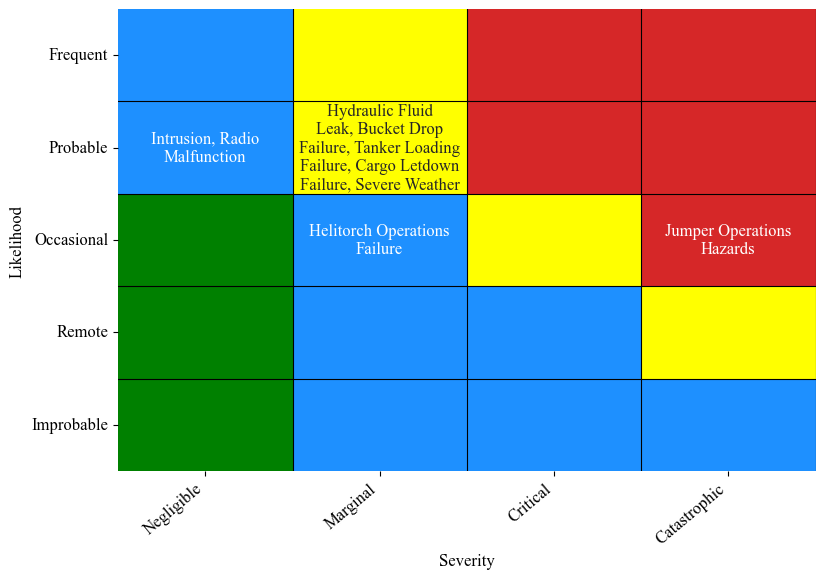

In [54]:
plot_USFS_risk_matrix(likelihood, severities_USFS, figsize=(9,6), save=False, results_path="SAFECOM_JAIS_USFS_risk_matrix", fontsize=12, max_chars=24, title=False)

# Situation Specific Risk Matrices

In [55]:
def filter_df(df, filters):
    for col in filters:
        df = df.dropna(subset=[col])
        df = df[df[col].apply(lambda x: filters[col] in x)].reset_index(drop=True)
    return df

In [56]:
def get_custom_rm(df, filters, hazard_file, results_file, keep_hazards=[]):
    preprocessed_df = filter_df(df, filters)
    frequency, docs, hazard_words_per_doc, topics_per_doc, hazard_topics_per_doc = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Narrative', 'Year', "Tracking #", 'Narrative', doc_topic_dist_field='document topic distribution', topic_thresh=0.2)
    rates = calc_rate(frequency)
    _, severities = calc_severity(docs, preprocessed_df, id_field='Tracking #')
    #replace nans with 0
    severities = {hazard:severities[hazard] if (not np.isnan(severities[hazard])) else 0 for hazard in severities}
    if keep_hazards == []: keep_hazards = [hazard for hazard in docs]
    #rm extra hazards
    severities = {hazard: severities[hazard] for hazard in severities if hazard in keep_hazards}
    rates = {hazard: rates[hazard] for hazard in rates if hazard in keep_hazards}
    severities_USFS = get_SAFECOM_severity_USFS(severities)
    likelihood = get_likelihood_USFS(rates)
    plot_USFS_risk_matrix(likelihood, severities_USFS, figsize=(9,7), save=False, results_path="", fontsize=10, max_chars=30, title=False)

### Example 1: Aerial commander flying an Aero Commander airplane in California

In [57]:
keep_hazards = ['Hydraulic Fluid Leak','Intrusion','Bucket Drop Failure','Radio Malfunction','Jumper Operations Hazards',
                'Tanker Loading Failure','Helitorch Operations Failure', 'Cargo Letdown Failure','Severe Weather',
               'Fuel System Malfunction', 'Landing Gear Malfunction', 'Engine Malfunction', 'Oil Malfunction', 'Control Surface Damage',
               'In-flight Collision', 'Door Failure']

100%|██████████| 26/26 [00:01<00:00, 23.37it/s]
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\srandrad\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


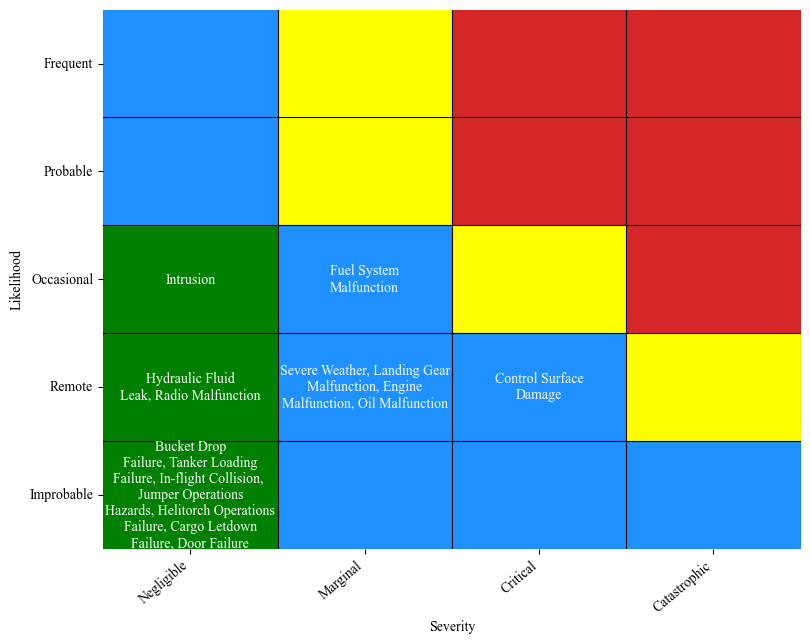

In [58]:
filters ={"Mission Type":'Fire, Air Attack',
          "Type":'Airplane',
         "Manufacturer":'Aero Commander',
         "region_corrected":'Region 05 Pacific Southwest Region'}
get_custom_rm(preprocessed_df, filters, hazard_file, results_file, keep_hazards)

### Example 2: Air Tanker flying a redardant drop mission with a Lockheed multi-engine in Oregon

100%|██████████| 26/26 [00:00<00:00, 41.04it/s]


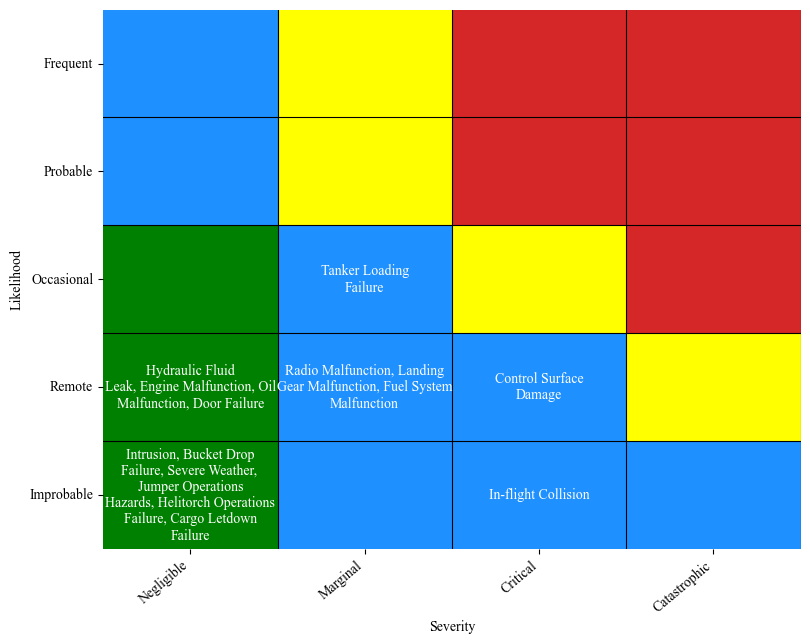

In [59]:
filters ={"Mission Type":'Fire, Retardant Drop (Airtanker)',
         "Type":'Airtanker (Multi-Engine)',
          "Manufacturer": "Lockheed",
         'region_corrected':'Region 06 Pacific Northwest Region'}
get_custom_rm(preprocessed_df, filters, hazard_file, results_file, keep_hazards)

### Example 3: Pilot flying a Bell Helicopter for reconnaisance in Texas

100%|██████████| 26/26 [00:00<00:00, 44.55it/s]


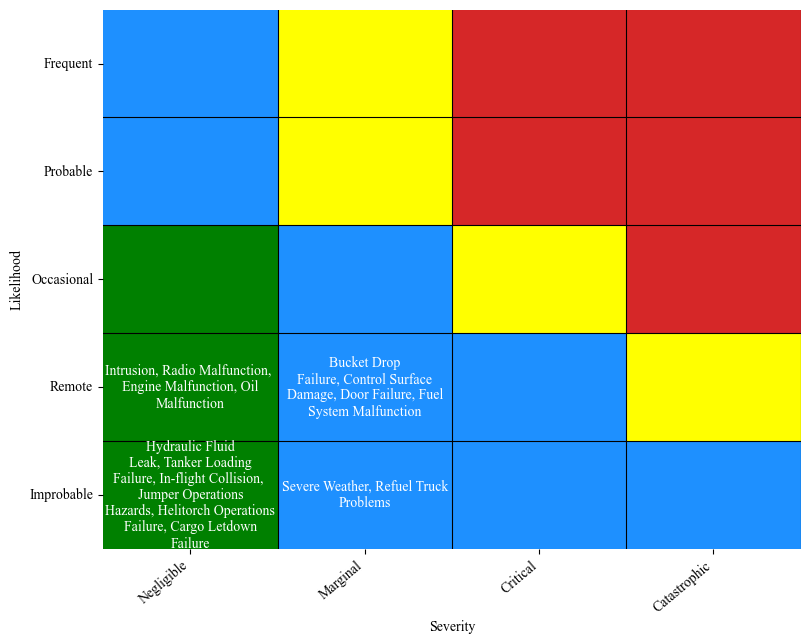

In [60]:
filters ={"Mission Type":'Fire, Reconnaissance',
         "Type":'Helicopter',
          "Manufacturer": "Bell",
          #"Model":"600",#includes 600
          'region_corrected':'Region 08 Southern Area Region'}
keep_hazards = ['Hydraulic Fluid Leak','Intrusion','Bucket Drop Failure','Radio Malfunction','Jumper Operations Hazards',
                'Tanker Loading Failure','Helitorch Operations Failure', 'Cargo Letdown Failure','Severe Weather',
               'Fuel System Malfunction', 'Engine Malfunction', 'Oil Malfunction', 'Control Surface Damage',
               'In-flight Collision', 'Door Failure', 'Refuel Truck Problems']
get_custom_rm(preprocessed_df, filters, hazard_file, results_file, keep_hazards)